# Neural network

### Data

In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split

# Importing the dataset
df = pd.read_csv('data/creditcard.csv')
df = df.drop(['Time'], axis=1)
df.reset_index(drop=True, inplace=True)

# Feature Scaling
X = (df.drop(['Class'], axis=1).values)
medians = np.median(X)
q1 = np.quantile(X, 0.25)
q3 = np.quantile(X, 0.75)
iqr = np.where(q3 - q1 == 0, 0.0001, q3 - q1)

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split((df.drop(['Class'], axis=1) - medians) / iqr, df['Class'], test_size = 0.4, random_state = 1)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 1)


### Model

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.utils import class_weight
from tensorflow.keras.metrics import F1Score

indput_d = X_train.shape[1]

# Compute class weights
class_weights = class_weight.compute_class_weight( class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

# Custom metrics
def precision(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    precision_val = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision_val

def recall(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    recall_val = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall_val

def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f1_val = 2 * (p * r) / (p + r + tf.keras.backend.epsilon())
    return f1_val

# Define the model
model = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=[indput_d]),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid'),
])

# Compile the model
model.compile(
    optimizer='RMSprop',
    loss='binary_crossentropy',
    metrics=['accuracy', f1_score, precision, recall],
)
epochs = 10
batch_size = 32
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)

# Train the model
H = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    epochs=epochs,
    verbose=2,
    class_weight=class_weights_dict,
    callbacks=[callback]
)

Epoch 1/10
5341/5341 - 45s - loss: 41.4103 - accuracy: 0.9985 - f1_score: 0.0275 - precision: 0.0275 - recall: 0.0277 - val_loss: 0.0762 - val_accuracy: 0.9993 - val_f1_score: 0.0337 - val_precision: 0.0337 - val_recall: 0.0337 - 45s/epoch - 9ms/step
Epoch 2/10
5341/5341 - 36s - loss: 40.3364 - accuracy: 0.9989 - f1_score: 0.0335 - precision: 0.0338 - recall: 0.0335 - val_loss: 0.0994 - val_accuracy: 0.9993 - val_f1_score: 0.0337 - val_precision: 0.0337 - val_recall: 0.0337 - 36s/epoch - 7ms/step
Epoch 3/10
5341/5341 - 38s - loss: 42.4799 - accuracy: 0.9988 - f1_score: 0.0305 - precision: 0.0308 - recall: 0.0304 - val_loss: 0.1421 - val_accuracy: 0.9993 - val_f1_score: 0.0348 - val_precision: 0.0348 - val_recall: 0.0348 - 38s/epoch - 7ms/step
Epoch 4/10
5341/5341 - 37s - loss: 46.9309 - accuracy: 0.9987 - f1_score: 0.0330 - precision: 0.0329 - recall: 0.0332 - val_loss: 0.0805 - val_accuracy: 0.9994 - val_f1_score: 0.0365 - val_precision: 0.0365 - val_recall: 0.0365 - 37s/epoch - 7ms/s

In [3]:
# Evaluate the model
score = model.evaluate(X_test, y_test, verbose=1)
print("Score: ", score)

1781/1781 [==============================] - 7s 4ms/step - loss: 0.3367 - accuracy: 0.9991 - f1_score: 0.0333 - precision: 0.0334 - recall: 0.0334
Score:  [0.33673757314682007, 0.9990695714950562, 0.03331461548805237, 0.03340819478034973, 0.03340819478034973]


In [4]:
def f1(y_pred, y_test):
    y_pred = y_pred.flatten()
    tp = (y_pred * y_test).sum()
    fp = (y_pred * (1 - y_test)).sum()
    fn = ((1 - y_pred) * y_test).sum()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    return f1

In [7]:
import seaborn as sns
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
y_pred = (model.predict(X_test) > 0.5).astype(int)
print('F1Score: ', f1( y_pred, y_test))
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True, target_names=['Not Fraud', 'Fraud']))

1781/1781 [==============================] - 6s 3ms/step
F1Score:  0.6971428571428572


,Not Fraud,Fraud,accuracy,macro avg,weighted avg
precision,0.999350,0.792208,0.99907,0.895779,0.998993
recall,0.999719,0.622449,0.99907,0.811084,0.999070
f1-score,0.999534,0.697143,0.99907,0.848338,0.999014
support,56864.000000,98.000000,0.99907,56962.000000,56962.000000


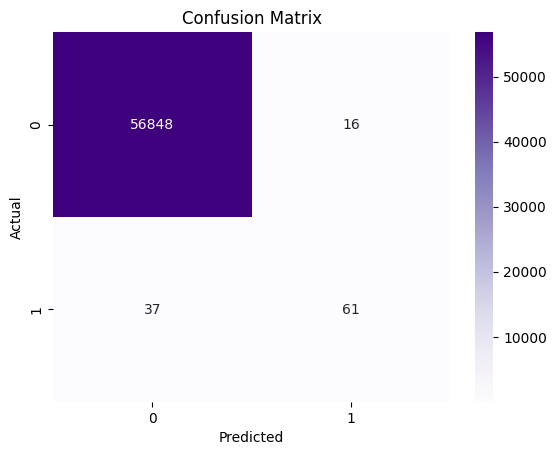

In [10]:
confusion_matrix = pd.crosstab(y_test.T, y_pred.T, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, cmap='Purples', fmt='g')
plt.title('Confusion Matrix')
plt.savefig('ressources/plots/confusion_matrix_dl.png')